In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)


In [4]:
applications = pd.read_csv('../../data/home-credit-default-risk/application_train.csv')
applications.columns = applications.columns.str.lower()
applications.Name = 'applications'

X = applications.drop(columns=['target'])  # Variables predictoras
y = applications['target']                 # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

app = pd.concat([X_train, y_train], axis=1)
app.Name = 'applications_train'

In [5]:
bureau = pd.read_csv('../../data/home-credit-default-risk/bureau.csv')
bureau.columns = bureau.columns.str.lower()

bureau_balance = pd.read_csv('../../data/home-credit-default-risk/bureau_balance.csv')
bureau_balance.columns = bureau_balance.columns.str.lower()

prev_app = pd.read_csv('../../data/home-credit-default-risk/previous_application.csv')
prev_app.columns = prev_app.columns.str.lower()

pos_cash = pd.read_csv('../../data/home-credit-default-risk/POS_CASH_balance.csv')
pos_cash.columns = pos_cash.columns.str.lower()

credit_card = pd.read_csv('../../data/home-credit-default-risk/credit_card_balance.csv')
credit_card.columns = credit_card.columns.str.lower()

installments = pd.read_csv('../../data/home-credit-default-risk/installments_payments.csv')
installments.columns = installments.columns.str.lower()

In [6]:
aux = applications.select_dtypes(include=['number']).groupby('target').mean().T
aux['diff'] = aux[1] /  aux[0]
aux.sort_values('diff', ascending=False).head(20)

target,0,1,diff
flag_document_2,0.000032,0.000161,5.060956
flag_document_21,0.000315,0.000564,1.791237
reg_city_not_live_city,0.074641,0.118389,1.586106
def_60_cnt_social_circle,0.096688,0.138247,1.429829
def_30_cnt_social_circle,0.139148,0.191980,1.379689
reg_city_not_work_city,0.224090,0.302920,1.351783
live_city_not_work_city,0.175856,0.221672,1.260530
flag_work_phone,0.195991,0.237825,1.213445
reg_region_not_live_region,0.014942,0.017442,1.167291
amt_req_credit_bureau_day,0.006914,0.008036,1.162328


In [7]:
aux.sort_values('diff', ascending=False).tail(20)

target,0,1,diff
ext_source_2,0.523479,0.410935,0.785008
elevators_mode,0.075647,0.058880,0.778360
elevators_avg,0.080194,0.062036,0.773573
elevators_medi,0.079317,0.061352,0.773501
flag_document_11,0.003990,0.003021,0.757124
ext_source_1,0.511461,0.386968,0.756593
ext_source_3,0.520969,0.390717,0.749981
flag_document_9,0.003976,0.002981,0.749688
flag_document_18,0.008341,0.005720,0.685740
flag_document_6,0.090457,0.060705,0.671090


In [8]:
applications.isna().mean().sort_values(ascending=False).head(60)

commonarea_medi                 0.698723
commonarea_avg                  0.698723
commonarea_mode                 0.698723
nonlivingapartments_mode        0.694330
nonlivingapartments_avg         0.694330
nonlivingapartments_medi        0.694330
fondkapremont_mode              0.683862
livingapartments_mode           0.683550
livingapartments_avg            0.683550
livingapartments_medi           0.683550
floorsmin_avg                   0.678486
floorsmin_mode                  0.678486
floorsmin_medi                  0.678486
years_build_medi                0.664978
years_build_mode                0.664978
years_build_avg                 0.664978
own_car_age                     0.659908
landarea_medi                   0.593767
landarea_mode                   0.593767
landarea_avg                    0.593767
basementarea_medi               0.585160
basementarea_avg                0.585160
basementarea_mode               0.585160
ext_source_1                    0.563811
nonlivingarea_mo

In [9]:
applications.target.groupby(applications.amt_req_credit_bureau_day).mean()

amt_req_credit_bureau_day
0.0    0.077096
1.0    0.096749
2.0    0.103774
3.0    0.044444
4.0    0.115385
5.0    0.000000
6.0    0.000000
8.0    0.000000
9.0    0.000000
Name: target, dtype: float64

In [10]:
user = bureau[bureau.credit_day_overdue>0].sk_id_curr.sample(1).values[0]
bureau[bureau.sk_id_curr == user]

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
1517049,296782,6709073,Closed,currency 1,-2688,0,-2475.0,-2504.0,NaN,0,20573.46,0.0,NaN,0.0,Consumer credit,-894,NaN
1517050,296782,6709074,Closed,currency 1,-2402,0,-2190.0,-2249.0,NaN,0,55392.57,0.0,NaN,0.0,Consumer credit,-894,NaN
1517051,296782,6709075,Active,currency 1,-2827,60,-2234.0,NaN,NaN,0,38443.50,23683.5,NaN,9.0,Consumer credit,-629,NaN
1517052,296782,6709076,Closed,currency 1,-1552,0,-1005.0,-1401.0,NaN,0,147487.50,0.0,NaN,0.0,Consumer credit,-584,NaN
1517053,296782,6709077,Closed,currency 1,-1954,0,-1772.0,-1760.0,NaN,0,36621.00,0.0,0.0,0.0,Consumer credit,-1012,0.000
1517054,296782,6709078,Closed,currency 1,-742,0,-438.0,-593.0,NaN,0,57289.50,0.0,0.0,0.0,Consumer credit,-572,0.000
1517055,296782,6709079,Closed,currency 1,-1397,0,-299.0,-1216.0,NaN,0,0.00,0.0,0.0,0.0,Credit card,-906,NaN
1517056,296782,6709080,Closed,currency 1,-1953,0,-1772.0,-1791.0,NaN,0,36621.00,0.0,NaN,0.0,Consumer credit,-1766,0.000
1517057,296782,6709081,Active,currency 1,-287,0,444.0,NaN,NaN,0,707400.00,498978.0,NaN,0.0,Consumer credit,-9,40950.000
1517058,296782,6709082,Active,currency 1,-75,0,291.0,NaN,8338.905,0,159282.00,140926.5,0.0,0.0,Consumer credit,-14,13273.515


In [11]:
# Features básicas
df = applications[['sk_id_curr', 'target']].copy()

df['amt_credit'] = applications['amt_credit']
df['amt_annuity'] = applications['amt_annuity']

# Edad
df['days_birth'] = applications['days_birth']
df['edad_anios'] = abs(applications['days_birth']) / 365.25
df.drop(columns=['days_birth'], inplace=True)

df['ext_source_1'] = applications['ext_source_1']
df['ext_source_2'] = applications['ext_source_2']
df['ext_source_3'] = applications['ext_source_3']

#generate a boolean for ext_source_1 is na
df['ext_source_1_na'] = df['ext_source_1'].isna().astype(int)
df['ext_source_2_na'] = df['ext_source_2'].isna().astype(int)
df['ext_source_3_na'] = df['ext_source_3'].isna().astype(int)


df['flag_amt_req_bureau_qrt_le_3'] = (applications['amt_req_credit_bureau_qrt'] <= 3).astype(int)


# Familia y genero
df['name_family_status'] = applications['name_family_status']
df['cnt_children'] = applications['cnt_children']
df['cnt_fam_members'] = applications['cnt_fam_members']
df['code_gender'] = applications['code_gender']
df['def_60_cnt_social_circle'] = applications['def_60_cnt_social_circle']
df['def_30_cnt_social_circle'] = applications['def_30_cnt_social_circle']

#Educacion e ingreso
df['name_education_type'] = applications['name_education_type']
mean_by_edu = df.groupby('name_education_type')['target'].mean().sort_values()
edu_mapping = {cat: i for i, cat in enumerate(mean_by_edu.index, start=1)}
df['education_type'] = df['name_education_type'].map(edu_mapping)
df.drop(columns=['name_education_type'], inplace=True)
df['amt_income_total'] = applications['amt_income_total']
df['credit_income_ratio'] = df['amt_credit'] / df['amt_income_total']

df['income_per_capita'] = np.where(
    df['cnt_fam_members'] > 0,
    df['amt_income_total'] / df['cnt_fam_members'],
    df['amt_income_total']
)

df['days_employed'] = applications['days_employed']

# Activos
df['flag_own_car'] = applications['flag_own_car']
df['flag_own_realty'] = applications['flag_own_realty']

#identidad sintética
df['flag_registered_city_not_living_city'] = applications['reg_city_not_live_city']
df['flag_registed_region_not_living_region'] = applications['reg_region_not_live_region']
df['flag_amt_req_credit_bureau_day_gt_one'] = (applications['amt_req_credit_bureau_day'] > 1).astype(int)

#lifts sobre documentos (probablemente relacionados a identidad)
df['flag_document_2'] = applications['flag_document_2']
df['flag_document_21'] = applications['flag_document_21']
df['flag_document_10'] = applications['flag_document_10']
df['flag_document_4'] = applications['flag_document_4']
df['flag_document_12'] = applications['flag_document_12']
df['flag_document_17'] = applications['flag_document_17']
df['flag_document_15'] = applications['flag_document_15']

join_with_bureau = pd.merge(applications, bureau, on='sk_id_curr', how='left', suffixes=('', '_bureau'))

df['active_credits_count'] = join_with_bureau[join_with_bureau['credit_active'] == 'Active'].groupby('sk_id_curr').size()
df['closed_credits_count'] = join_with_bureau[join_with_bureau['credit_active'] == 'Closed'].groupby('sk_id_curr').size()
df['flag_credit_day_overdue'] = join_with_bureau.credit_day_overdue.groupby(join_with_bureau.sk_id_curr).mean() > 0

join_with_credit_card = pd.merge(applications, credit_card[credit_card.months_balance > -5], on='sk_id_curr', how='left', suffixes=('', '_credit_card'))
df['mean_balance'] = join_with_credit_card['amt_balance'].groupby(join_with_credit_card.sk_id_curr).mean()
df['mean_credit_limit'] = join_with_credit_card['amt_credit_limit_actual'].groupby(join_with_credit_card.sk_id_curr).mean()
df['mean_utilization'] = np.where(
    df['mean_credit_limit'] > 0,
    df['mean_balance'] / df['mean_credit_limit'],
    np.nan
)
df['mean_sk_dpd'] = join_with_credit_card['sk_dpd'].groupby(join_with_credit_card.sk_id_curr).mean()

df.isna().mean().sort_values(ascending=False).head(20)

mean_utilization                         0.874203
mean_sk_dpd                              0.835915
mean_balance                             0.835915
mean_credit_limit                        0.835915
active_credits_count                     0.588977
closed_credits_count                     0.564061
ext_source_1                             0.563811
flag_credit_day_overdue                  0.417670
ext_source_3                             0.198253
def_60_cnt_social_circle                 0.003320
def_30_cnt_social_circle                 0.003320
ext_source_2                             0.002146
amt_annuity                              0.000039
cnt_fam_members                          0.000007
flag_document_10                         0.000000
flag_amt_req_credit_bureau_day_gt_one    0.000000
flag_document_2                          0.000000
flag_document_21                         0.000000
flag_document_15                         0.000000
flag_document_4                          0.000000


In [ ]:
# Entrenamiento con XGBoost y evaluación de métricas
model_df = df.drop(columns=['sk_id_curr']).copy()

feature_cols = [col for col in model_df.columns if col != 'target']
X = model_df[feature_cols].copy()
y = model_df['target'].copy()

bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, dummy_na=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

base_xgb = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.03, 0.05, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.6, 0.8],
    'reg_lambda': [1.0, 2.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print('Best params:', grid_search.best_params_)
print(f"Best CV ROC AUC: {grid_search.best_score_:.4f}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 2.0, 'subsample': 0.9}
Best CV ROC AUC: 0.7492
ROC AUC: 0.7528
PR AUC: 0.2397


,total,positives,tpr
decile,,,
1,6151,1651,0.332528
2,6150,892,0.512185
3,6150,627,0.638469
4,6150,498,0.738771
5,6151,393,0.817925
6,6150,287,0.875730
7,6150,229,0.921853
8,6150,163,0.954683
9,6150,129,0.980665


In [15]:
# Entrenamiento con XGBoost y evaluación de métricas
model_df = df.drop(columns=['sk_id_curr']).copy()

feature_cols = [col for col in model_df.columns if col != 'target']
X = model_df[feature_cols].copy()
y = model_df['target'].copy()

bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, dummy_na=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

best_model = best_model = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    
    # Hiperparámetros obtenidos del GridSearch:
    colsample_bytree=0.6,
    learning_rate=0.03,
    max_depth=5,
    n_estimators=500,
    reg_lambda=2.0,
    subsample=0.9,
)

best_model.fit(X_train, y_train)
y_proba = best_model.predict_proba(X_test)[:, 1]


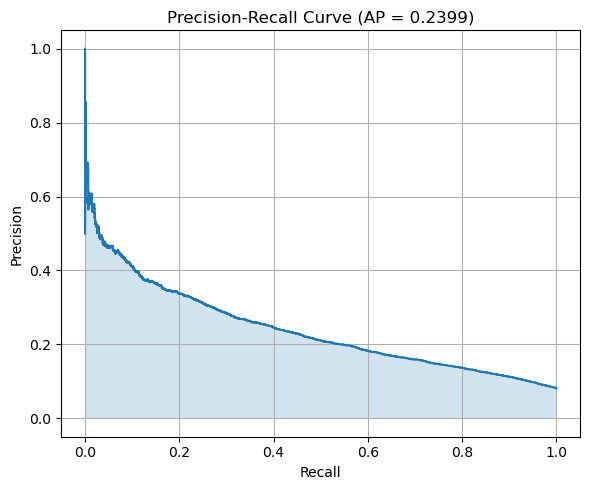

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ya tienes y_true e y_proba; pero por claridad lo recalculo aquí:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.step(recall, precision, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {pr_auc:.4f})')
plt.grid(True)
plt.tight_layout()
plt.show()

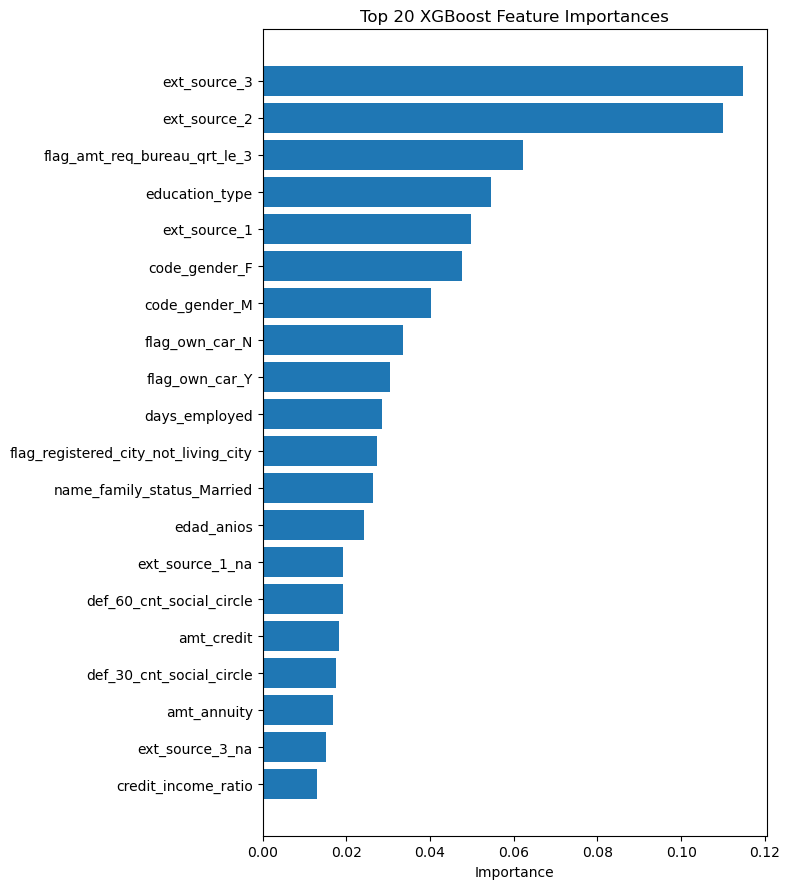

In [17]:
# Importancias del modelo (misma orden que X_train.columns)
feature_importances = best_model.feature_importances_
feature_names = X_train.columns

# Lo convertimos en DataFrame para ordenar
fi_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })
    .sort_values('importance', ascending=False)
)

# Cuántas mostrar (puedes cambiar a 30, 50, etc.)
top_n = 20
fi_top = fi_df.head(top_n).iloc[::-1]  # invertimos para que la más importante quede arriba en el barh

plt.figure(figsize=(8, 0.4 * top_n + 1))
plt.barh(fi_top['feature'], fi_top['importance'])
plt.xlabel('Importance')
plt.title(f'Top {top_n} XGBoost Feature Importances')
plt.tight_layout()
plt.show()

 97%|=================== | 1945/2000 [00:11<00:00]       

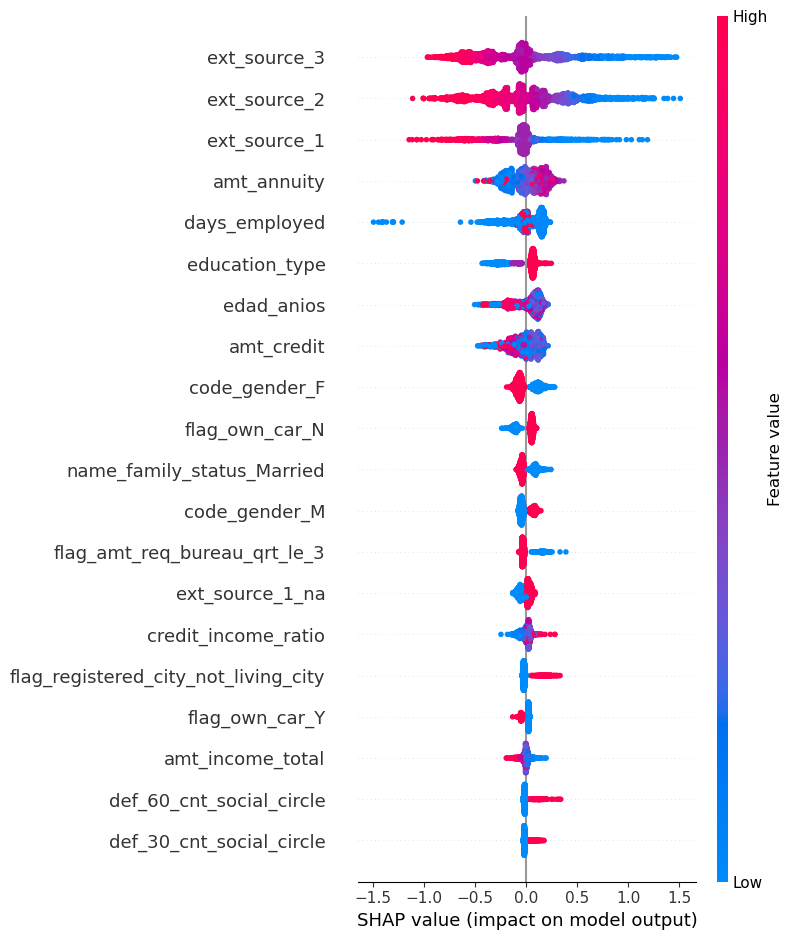

In [20]:
import numpy as np
import shap

shap.initjs()

# 1) Fuerza todo a tipo numérico
X_train_shap = X_train.astype(np.float32)
X_test_shap  = X_test.astype(np.float32)

# 2) (Opcional) background sample, pero ya en float32
X_bg = X_train_shap.sample(n=min(1000, len(X_train_shap)), random_state=42)

# 3) Explainer sobre el modelo
explainer = shap.TreeExplainer(best_model, data=X_bg)

# 4) Sample de test para graficar
X_test_sample = X_test_shap.sample(n=min(2000, len(X_test_shap)), random_state=42)

shap_values = explainer.shap_values(X_test_sample)

shap.summary_plot(
    shap_values,
    X_test_sample,
    show=True
)